In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from astropy import units as u
from scipy.stats import norm
from scipy.signal import find_peaks
from specutils.spectra import Spectrum1D
from pytodcor.xcor.todcor import todcor
from pytodcor.lib.spectrum import Spectrum

This notebook captures unit tests for the `todcor` function. The same tests are defined in a unittest .py file, but the notebook allows for further interactivity and visualization for debugging purposes when needed.

Case Parameters:
  - Is Observed X-Axis Identical To Templates' X-Axis? TRUE

  - Is There No Shift Between Observed Feature and Template Feature? TRUE

  - Is There No Difference In Shape Of Observed Feature Height Compared To Template? TRUE

  - Is There No Difference in Shape Of Observed Feature Width Compared To Template? TRUE

  - Is The Scaling Ratio Between Model Templates Fixed? TRUE


# Case #1:

Observed and Template X-Axes are identical so no special considerations for gaps between template and observed wavelength coverage. The features in the observed spectrum and templates are at the same x-axis location, so the algorithm should find no need to apply a shift to match. The height and width of the observed spectral features are identical to the templates, so the algorithm should find exactly two peaks when shifting both models (4 total peaks.) The scaling ratio between the two models is fixed to 1.0.

In [2]:
# Generate the Gaussians to use.
gauss_1_peak = 5380.
gauss_2_peak = 5420.
xvals = np.linspace(5300., 5500., 1000)
g1_y = norm.pdf(xvals, gauss_1_peak, 4.)
g2_y = norm.pdf(xvals, gauss_2_peak, 4.)

obs_y = g1_y + g2_y
mod1_y = g1_y
mod2_y = g2_y

In [3]:
# Identify how many data points separate the two peaks. This is used later when checking results.
n_pix_apart = len(np.where((xvals >= gauss_1_peak) & (xvals <= gauss_2_peak))[0])

In [4]:
# Create Spectrum objects out of the simulated datasets.
obs_spec1d = Spectrum1D(flux=obs_y*u.dimensionless_unscaled,
                           spectral_axis=xvals*u.angstrom)
obs_spec = Spectrum(name="Case_01_Obs", air_or_vac="vacuum")
obs_spec.add_spec_part(obs_spec1d)

mod1_spec1d = Spectrum1D(flux=mod1_y*u.dimensionless_unscaled,
                           spectral_axis=xvals*u.angstrom)
mod1_spec = Spectrum(name="Case_01_Mod1", air_or_vac="vacuum")
mod1_spec.add_spec_part(mod1_spec1d)

mod2_spec1d = Spectrum1D(flux=mod2_y*u.dimensionless_unscaled,
                           spectral_axis=xvals*u.angstrom)
mod2_spec = Spectrum(name="Case_01_Mod2", air_or_vac="vacuum")
mod2_spec.add_spec_part(mod2_spec1d)

        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]


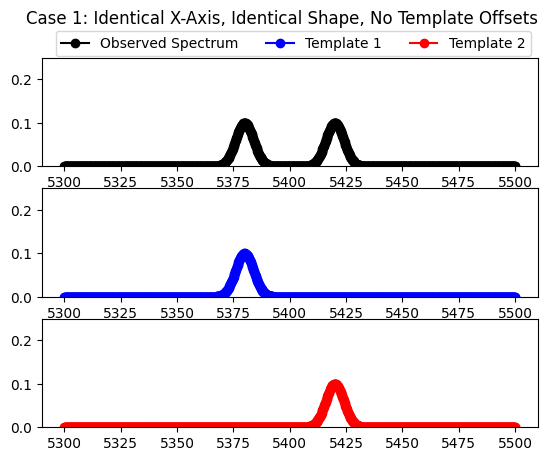

In [5]:
# Visualize the spectrum and templates.
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_ylim([0., 0.25])
ax2.set_ylim([0., 0.25])
ax3.set_ylim([0., 0.25])
ax1.plot(obs_spec.parts[0].spectral_axis, obs_spec.parts[0].flux, '-ko', label="Observed Spectrum")
ax2.plot(mod1_spec.parts[0].spectral_axis, mod1_spec.parts[0].flux, '-bo', label="Template 1")
ax3.plot(mod2_spec.parts[0].spectral_axis, mod2_spec.parts[0].flux, '-ro', label="Template 2")
fig.suptitle("Case 1: Identical X-Axis, Identical Shape, No Template Offsets")
fig.legend(ncols=3, bbox_to_anchor=[0.9, 0.95])
plt.show()

In [6]:
# Compute the TODCOR result.
todcor_pixshifts, vel_per_pix, todcor_vals, todcor_alphas = todcor(obs_spec.parts[0], mod1_spec.parts[0],
                                                      mod2_spec.parts[0], 400, fixed_alpha=1.,
                                                      vel_range=[-500., 500.])

Resampling observed spectrum and first template to a common log-lambda wavelength scale...
...total time taken = 0.04995499999999997 seconds.
Resampling observed spectrum and second template to a common log-lambda wavelength scale...
...total time taken = 0.046764999999999946 seconds.
Calculating cross-correlations...
...total time taken = 0.0008410000000000917 seconds.
Calculating TODCOR values and populating the two-dimensional surface...
...total time taken = 28.064363 seconds.


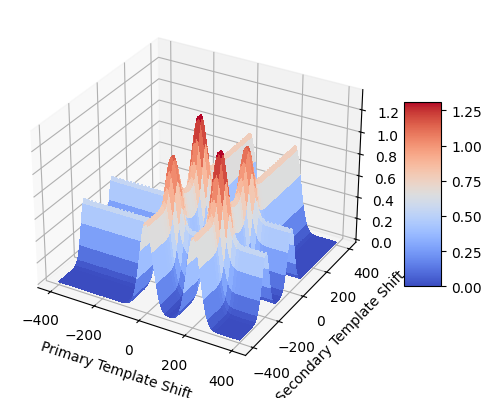

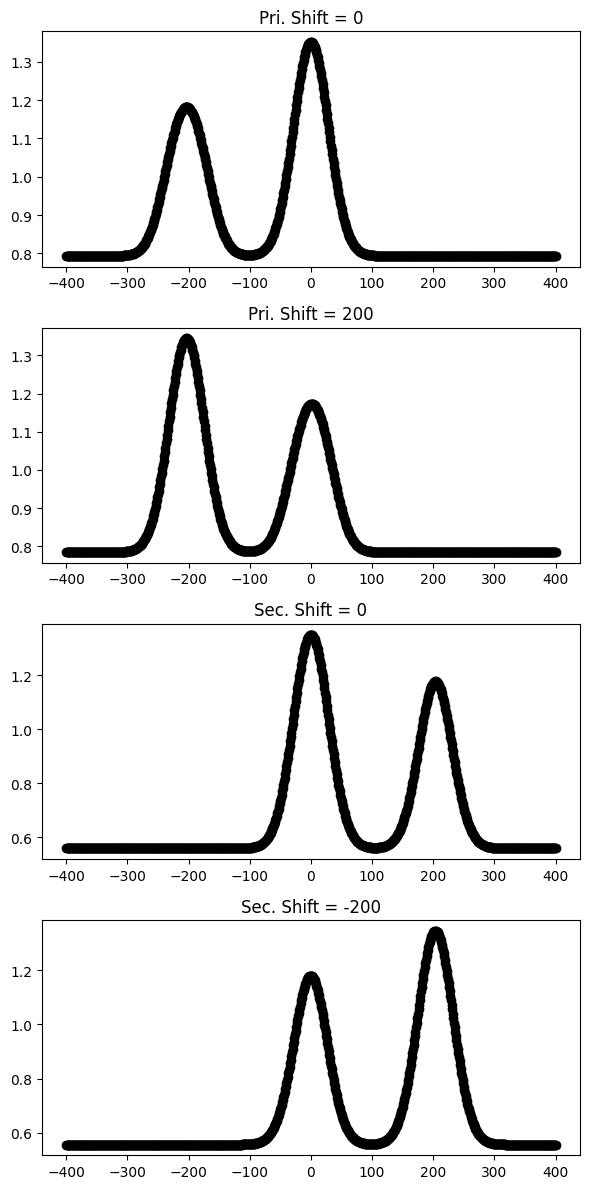

In [7]:
# Plot the TODCOR values as a projection across the two template shifts.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(todcor_pixshifts, todcor_pixshifts, indexing='ij')
Z = todcor_vals
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("Primary Template Shift")
ax.set_ylabel("Secondary Template Shift")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Plot slices along a specified shift of one of the templates.
x_fix_shift_1 = 0
x_fix_shift_2 = n_pix_apart
y_fix_shift_1 = 0
y_fix_shift_2 = -1*n_pix_apart

where_x1 = np.where(todcor_pixshifts == x_fix_shift_1)[0][0]
where_x2 = np.where(todcor_pixshifts == x_fix_shift_2)[0][0]

where_y1 = np.where(todcor_pixshifts == y_fix_shift_1)[0][0]
where_y2 = np.where(todcor_pixshifts == y_fix_shift_2)[0][0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(6, 12))

# Calculating peaks and their values along the slices for each template.
peak1_pri_shift0, peak2_pri_shift0 = find_peaks(todcor_vals[where_x1, :])[0] - 400
peak1_pri_shift200, peak2_pri_shift200 = find_peaks(todcor_vals[where_x2, :])[0] - 400
peak1_sec_shift0, peak2_sec_shift0 = find_peaks(todcor_vals[:, where_y1])[0] - 400
peak1_sec_shift200, peak2_sec_shift200 = find_peaks(todcor_vals[:, where_y2])[0] - 400

val1_pri_shift0, val2_pri_shift0 = todcor_vals[where_x1, :][peak1_pri_shift0 + 400], todcor_vals[where_x1, :][peak2_pri_shift0 + 400]
val1_pri_shift200, val2_pri_shift200  = todcor_vals[where_x2, :][peak1_pri_shift200 + 400], todcor_vals[where_x2, :][peak2_pri_shift200 + 400]
val1_sec_shift0, val2_sec_shift0 = todcor_vals[:, where_y1][peak1_sec_shift0 + 400], todcor_vals[:, where_y1][peak2_sec_shift0 + 400]
val1_sec_shift200, val2_sec_shift200 = todcor_vals[:, where_y2][peak1_sec_shift200 + 400], todcor_vals[:, where_y2][peak2_sec_shift200 + 400]

ax1.plot(todcor_pixshifts, todcor_vals[where_x1, :], '-ko')
ax1.set_title(f"Pri. Shift = 0\nMax Correlation at: {peak1_pri_shift0} and {peak2_pri_shift0}, values: {val1_pri_shift0} and {val2_pri_shift0}")
ax1.axvline(x=peak1_pri_shift0, color="blue")
ax1.axvline(x=peak2_pri_shift0, color="red")
ax2.plot(todcor_pixshifts, todcor_vals[where_x2, :], '-ko')
ax2.set_title(f"Pri. Shift = 200\nMax Correlation at: {peak1_pri_shift200} and {peak2_pri_shift200}, values: {val1_pri_shift200} and {val2_pri_shift200}")
ax2.axvline(x=peak1_pri_shift200, color="red")
ax2.axvline(x=peak2_pri_shift200, color="blue")
ax3.plot(todcor_pixshifts, todcor_vals[:, where_y1], '-ko')
ax3.set_title(f"Sec. Shift = 0\nMax Correlation at: {peak1_sec_shift0} and {peak2_sec_shift0}, values: {val1_sec_shift0} and {val2_sec_shift0}")
ax3.axvline(x=peak1_sec_shift0, color="red")
ax3.axvline(x=peak2_sec_shift0, color="blue")
ax4.plot(todcor_pixshifts, todcor_vals[:, where_y2], '-ko')
ax4.set_title(f"Sec. Shift = 200\nMax Correlation at: {peak1_sec_shift200} and {peak2_sec_shift200}, values: {val1_sec_shift200} and {val1_sec_shift200}")
ax4.axvline(x=peak1_sec_shift200, color="blue")
ax4.axvline(x=peak2_sec_shift200, color="red")
fig.tight_layout()
plt.show()